# Analysis of data of Paul et al. (2015)

This is based on a more extensive R tutorial by M. Büttner available from https://github.com/theislab/scAnalysisTutorial.

In [1]:
from sys import path
path.insert(0,'..')
import scanpy as sc
import numpy as np

# set very low png resolution, to decrease storage space
sc.sett.dpi(30)
# show some output
sc.sett.verbosity = 1

Get the data.

In [2]:
def paul15_raw():
    filename = 'data/paul15/paul15.h5'
    url = 'http://falexwolf.de/data/paul15.h5'
    ddata = sc.read(filename, 'data.debatched', backup_url=url)
    # the data has to be transposed (in the hdf5 and R files, each row                                                                                                               
    # corresponds to one gene, we use the opposite convention)                                                                                                                       
    ddata = sc.transpose_ddata(ddata)
    # define local variables to manipulate                                                                                                                                           
    X = ddata['X']
    genenames = ddata['colnames']
    # cluster assocations identified by Paul et al.                                                                                                                                  
    # groupnames_n = sc.read(filename,'cluster.id')['X']                                                                                                                             
    infogenenames = sc.read(filename, 'info.genes_strings')['X']
    # print('the first 10 informative gene names are', infogenenames[:10])
    # just keep the first of the equivalent names for each gene                                                                                                                      
    genenames = np.array([gn.split(';')[0] for gn in genenames])
    # print('the first 10 trunkated gene names are', genenames[:10])
    # mask array for the informative genes                                                                                                                                           
    infogenes_idcs = np.array([(True if gn in infogenenames else False)
                                for gn in genenames])
    # restrict data array to the 3451 informative genes                                                                                                                              
    X = X[:, infogenes_idcs]
    genenames = genenames[infogenes_idcs]
    # print('after selecting info genes, the first 10 gene names are',
    #          genenames[:10])
    # write to dict                                                                                                                                                                  
    ddata['X'] = X
    ddata['colnames'] = genenames
    # set root cell as in Haghverdi et al. (2016)                                                                                                                                    
    ddata['xroot'] = X[840] # note that in Matlab/R, counting starts at 1 
    return ddata

reading sheet data.debatched from file ../data/paul15/paul15.h5
reading sheet info.genes_strings from file ../data/paul15/paul15.h5
computing Diffusion Map with method "local"
0:00:17.432 - computed distance matrix with metric = sqeuclidean
0:00:00.101 - determined k = 20 nearest neighbors of each point
0:00:00.426 - computed W (weight matrix) with "knn" = True
0:00:00.048 - computed K (anisotropic kernel)
0:00:00.096 - computed Ktilde (normalized anistropic kernel)
0:00:00.998 - computed Ktilde's eigenvalues:
[ 1.                0.99284239124065  0.96918877360182  0.94440982539501
  0.93200680698376  0.8945161846998   0.87862932487111  0.85561150822895
  0.84358415344857  0.82316095171039]
perform Diffusion Pseudotime Analysis
0:00:00.985 - computed M matrix
0:00:11.296 - computed Ddiff distance matrix
detect 1 branchings
tip points [1687  877 2156] = [third start end]
0:00:00.699 - finished branching detection


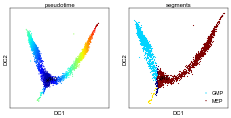

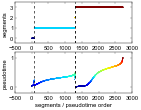

In [3]:
ddata = paul15_raw()
ddata = sc.subsample(ddata, 1)
ddata = sc.preprocess(ddata, 'log')

# perform DPT analysis
ddpt = sc.dpt(ddata, k=20, knn=True)
ddpt['groupnames'] = ['','GMP','','MEP']
sc.plot(ddpt, ddata)

testing groups ['GMP' 'MEP'] with ids [1 3]


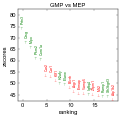

In [4]:
# perform differential gene expression test
ddifftest = sc.difftest(ddpt, ddata, groupnames=['GMP','MEP'], log=False)
sc.plot(ddifftest,ddata)